In [1]:
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.recurrent import SimpleRNN, LSTM, GRU
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Dropout, Flatten

from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adadelta, Adam


from tensorflow.contrib.keras.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.contrib.keras.python.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.contrib.keras.python.keras.models import load_model
from tensorflow.contrib.keras.python.keras.preprocessing import image
import numpy as np
import os

from IPython.display import clear_output

# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import time
import pickle

In [2]:
# network
TRAIN = 1
n_classes = 7
classes=np.array(('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'))

# data
REBUILD_DATA = 0
size = 224
video_length = 48
features_length = 2048

# training
# PATH_TRAIN = 'E:/EmotiW2017/lstm/aligned/Train_AFEW_original'
PATH_TRAIN = './Train_AFEW_original'
# PATH_TRAIN = 'E:/EmotiW2017/lstm/aligned/Train_AFEW_N'
NPY_X_TRAIN_DATA = 'training_data_x_resnet50_aligned.npy'
NPY_Y_TRAIN_DATA = 'training_data_y_resnet50_aligned.npy'
# NPY_X_TRAIN_DATA = 'training_data_x_resnet50_aligned_aug.npy'
# NPY_Y_TRAIN_DATA = 'training_data_y_resnet50_aligned_aug.npy'
# NPY_X_TRAIN_DATA = 'training_data_x_inceptionv3_aligned.npy'
# NPY_Y_TRAIN_DATA = 'training_data_y_inceptionv3_aligned.npy'

# validation
# PATH_VAL = 'E:/EmotiW2017/lstm/aligned/Val_AFEW_original'
PATH_VAL = './Val_AFEW_original'
NPY_X_VAL_DATA = 'val_data_x_resnet50_aligned.npy'
NPY_Y_VAL_DATA = 'val_data_y_resnet50_aligned.npy'
# NPY_X_VAL_DATA = 'val_data_x_inceptionv3_aligned.npy'
# NPY_Y_VAL_DATA = 'val_data_y_inceptionv3_aligned.npy'

# model
WEIGHT_FILE = 'resnet50_lstm_aligned.hdf5'
MODEL_FILE = 'resnet50_lstm_aligned.h5'
TRAINING_HIST = 'resnet50_lstm_aligned.pickle'
# WEIGHT_FILE = 'inceptionv3_lstm_aligned.hdf5'
# MODEL_FILE = 'inceptionv3_lstm_aligned.h5'
# TRAINING_HIST = 'inceptionv3_lstm_aligned.pickle'

# Feature Extraction with ResNet50

In [3]:
model = load_model('ResNet50_ImageNet.hdf5')
# model = load_model('InceptionV3_ImageNet.hdf5')
# model = InceptionV3(weights='imagenet', include_top=False)
# model.save('InceptionV3_ImageNet.hdf5')

C:\Program Files\Anaconda3\lib\site-packages\tensorflow\contrib\keras\python\keras\models.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
def extract_feature(img_path, model, size):
    img = image.load_img(img_path, target_size=(size, size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    
    return features[0][0][0]

# features = extract_feature('duong.jpg', model, size)
# features.shape

# Emotion to Integer Convertor

In [6]:
def emo2int(emo):
    if n_classes == 7:
        if emo == 'Angry':
            return 0
        elif emo == 'Disgust':
            return 1
        elif emo == 'Fear':
            return 2
        elif emo == 'Happy':
            return 3
        elif emo == 'Neutral':
            return 4
        elif emo == 'Sad':
            return 5
        else:
            return 6
    else:
        if emo == 'angry_happy_neutral':
            return 0
        else:
            return 1

# Confusion matrix

In [7]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Training Data Feature Extraction

In [8]:
if REBUILD_DATA == 0 and os.path.isfile(NPY_X_TRAIN_DATA) and os.path.isfile(NPY_Y_TRAIN_DATA):
    print('>>> loading training data...', end='')
    X_train = np.load(NPY_X_TRAIN_DATA)
    y_train = np.load(NPY_Y_TRAIN_DATA)
    print('done.')
else:
    # Count # of videos
    n_vids_train = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                n_vids_train += 1
    
    # Read images and extract features
    vid_indx = 0
    
    X_train = np.zeros((n_vids_train, video_length, features_length))
    y_train = []

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                # Extract features
                fra_indx = 0
                for fra in os.listdir(full_vid):
                    if fra_indx < video_length:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            # Clear screen
                            clear_output(wait=True)
                            print('> extracting features for video #%d/%d at frame #%d/%d' % (vid_indx + 1, n_vids_train, fra_indx + 1, video_length))
                            
                            features = extract_feature(full_fra, model, size)
                            
                            # Add extracted features to dataset
                            X_train[vid_indx, fra_indx, :] = features

                            fra_indx += 1
                    else:
                        break

                # Get the label for current video
                y_train.append(emo2int(emo))

                vid_indx += 1

    y_train = np.array(y_train)
    
    clear_output(wait=True)
    print('>>> processed %d videos' % (n_vids_train))

    np.save(NPY_X_TRAIN_DATA, X_train)
    np.save(NPY_Y_TRAIN_DATA, y_train)
    
print('\tshapes: {}, {}'.format(X_train.shape, y_train.shape))
print('\ttypes:  {}, {}'.format(X_train.dtype, y_train.dtype))
print('\tmemory: {} MB, {} MB'.format(X_train.nbytes / 1048576, y_train.nbytes / 1048576))

>>> loading training data...done.
	shapes: (726, 48, 2048), (726,)
	types:  float64, int32
	memory: 544.5 MB, 0.00276947021484375 MB


# Validation Data Feature Extraction

In [9]:
if REBUILD_DATA == 0 and os.path.isfile(NPY_X_VAL_DATA) and os.path.isfile(NPY_Y_VAL_DATA):
    print('>>> loading validation data...', end='')
    X_val = np.load(NPY_X_VAL_DATA)
    y_val = np.load(NPY_Y_VAL_DATA)
    print('done.')
else:
    # Count # of videos
    n_vids_val = 0

    for emo in os.listdir(PATH_VAL):
        full_emo = PATH_VAL + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                n_vids_val += 1
    
    # Read images and extract features
    vid_indx = 0
    
    X_val = np.zeros((n_vids_val, video_length, features_length))
    y_val = []

    for emo in os.listdir(PATH_VAL):
        full_emo = PATH_VAL + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                # Extract features
                fra_indx = 0
                for fra in os.listdir(full_vid):
                    if fra_indx < video_length:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            # Clear screen
                            clear_output(wait=True)
                            print('> extracting features for video #%d/%d at frame #%d/%d' % (vid_indx + 1, n_vids_val, fra_indx + 1, video_length))
                            
                            features = extract_feature(full_fra, model, size)
                            
                            # Add extracted features to dataset
                            X_val[vid_indx, fra_indx, :] = features

                            fra_indx += 1
                    else:
                        break

                # Get the label for current video
                y_val.append(emo2int(emo))

                vid_indx += 1

    y_val = np.array(y_val)
    
    clear_output(wait=True)
    print('>>> processed %d videos' % (n_vids_val))

    np.save(NPY_X_VAL_DATA, X_val)
    np.save(NPY_Y_VAL_DATA, y_val)
    
print('\tshapes: {}, {}'.format(X_val.shape, y_val.shape))
print('\ttypes:  {}, {}'.format(X_val.dtype, y_val.dtype))
print('\tmemory: {} MB, {} MB'.format(X_val.nbytes / 1048576, y_val.nbytes / 1048576))

>>> loading validation data...done.
	shapes: (383, 48, 2048), (383,)
	types:  float64, int32
	memory: 287.25 MB, 0.001461029052734375 MB


# LSTM

In [10]:
lstm = Sequential()
lstm.add(LSTM(2048, input_shape=(video_length, features_length),
               dropout=0.5, return_sequences=False))
# lstm.add(Flatten())
lstm.add(Dense(512, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(n_classes, activation='softmax'))

In [11]:
print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2048)              33562624  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 34,615,303.0
Trainable params: 34,615,303.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [12]:
if TRAIN == 1:
    batch_size = 172
    n_epochs = 10000

    learning_rate = 0.0001
    early_stop_after = 50
    
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_acc', patience=early_stop_after, verbose=1)
    checkpointer = ModelCheckpoint(monitor='val_acc', filepath='checkpoints/cnn_images' + '_' + str(size) + '_model.{epoch:05d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5', verbose=1, save_best_only=True)

    # opt = Adam(lr=learning_rate)
    opt = RMSprop(lr=learning_rate)
    lstm.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    train_history = lstm.fit(X_train, y_train,
                             validation_data=(X_val, y_val),
                             shuffle=True, batch_size=batch_size,
                             epochs=n_epochs,
                             verbose=1,
                             callbacks=[checkpointer, early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time: ' + str(training_time) + ' sec')

Train on 726 samples, validate on 383 samples
Epoch 1/10000
726/726 [==============================] - 6s - loss: 2.0326 - acc: 0.1694 - val_loss: 1.9139 - val_acc: 0.2115
Epoch 2/10000
726/726 [==============================] - 3s - loss: 1.8675 - acc: 0.2424 - val_loss: 1.9549 - val_acc: 0.2010
Epoch 3/10000
726/726 [==============================] - 5s - loss: 1.8451 - acc: 0.2466 - val_loss: 1.8683 - val_acc: 0.2245
Epoch 4/10000
726/726 [==============================] - 3s - loss: 1.7875 - acc: 0.2920 - val_loss: 1.9104 - val_acc: 0.2167
Epoch 5/10000
726/726 [==============================] - 5s - loss: 1.7753 - acc: 0.2975 - val_loss: 1.8866 - val_acc: 0.2507
Epoch 6/10000
726/726 [==============================] - 3s - loss: 1.7691 - acc: 0.3113 - val_loss: 1.8925 - val_acc: 0.2167
Epoch 7/10000
726/726 [==============================] - 3s - loss: 1.7233 - acc: 0.3361 - val_loss: 1.9284 - val_acc: 0.1984
Epoch 8/10000
726/726 [==============================] - 3s - loss: 1.71

726/726 [==============================] - 3s - loss: 1.1922 - acc: 0.5675 - val_loss: 3.0046 - val_acc: 0.2324
Epoch 32/10000
726/726 [==============================] - 3s - loss: 1.3174 - acc: 0.5193 - val_loss: 2.1379 - val_acc: 0.3264
Epoch 33/10000
726/726 [==============================] - 4s - loss: 1.1224 - acc: 0.6088 - val_loss: 2.3110 - val_acc: 0.3342
Epoch 34/10000
726/726 [==============================] - 3s - loss: 1.1274 - acc: 0.5620 - val_loss: 3.5204 - val_acc: 0.2089
Epoch 35/10000
726/726 [==============================] - 3s - loss: 1.2901 - acc: 0.5303 - val_loss: 2.4500 - val_acc: 0.2846
Epoch 36/10000
726/726 [==============================] - 3s - loss: 1.1239 - acc: 0.6033 - val_loss: 2.6966 - val_acc: 0.3029
Epoch 37/10000
726/726 [==============================] - 3s - loss: 1.1052 - acc: 0.5895 - val_loss: 2.7309 - val_acc: 0.2742
Epoch 38/10000
726/726 [==============================] - 3s - loss: 1.0632 - acc: 0.5978 - val_loss: 2.4864 - val_acc: 0.3055

726/726 [==============================] - 3s - loss: 0.7192 - acc: 0.7438 - val_loss: 3.4316 - val_acc: 0.2350
Epoch 65/10000
726/726 [==============================] - 3s - loss: 0.6072 - acc: 0.7782 - val_loss: 3.4141 - val_acc: 0.2663
Epoch 66/10000
726/726 [==============================] - 3s - loss: 0.6539 - acc: 0.7796 - val_loss: 3.3388 - val_acc: 0.2977
Epoch 67/10000
726/726 [==============================] - 3s - loss: 0.5957 - acc: 0.7906 - val_loss: 3.5506 - val_acc: 0.2611
Epoch 68/10000
726/726 [==============================] - 3s - loss: 0.5855 - acc: 0.8099 - val_loss: 3.5715 - val_acc: 0.2585
Epoch 69/10000
726/726 [==============================] - 3s - loss: 0.6259 - acc: 0.7796 - val_loss: 4.0110 - val_acc: 0.2298
Epoch 70/10000
726/726 [==============================] - 3s - loss: 0.5878 - acc: 0.8099 - val_loss: 3.3186 - val_acc: 0.2794
Epoch 71/10000
726/726 [==============================] - 3s - loss: 0.5885 - acc: 0.8030 - val_loss: 3.6410 - val_acc: 0.2924

# Save model OR Load trained model

In [13]:
if TRAIN == 1:
    # Save trained model
    lstm.save_weights(WEIGHT_FILE)
    lstm.save(MODEL_FILE)
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(train_history.history, f)
        
    history_ = train_history.history
else:
    # Load trained model
    WEIGHT_FILE = 'checkpoints/cnn_images_224_model.00032-1.1224-0.6088-2.3110-0.3342.hdf5'
    lstm.load_weights(WEIGHT_FILE)
    # lstm = load_model(MODEL_FILE)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)

In [15]:
# Load trained model
WEIGHT_FILE = 'checkpoints/cnn_images_224_model.00032-1.1224-0.6088-2.3110-0.3342.hdf5'
lstm.load_weights(WEIGHT_FILE)

# Load training history
file = open(TRAINING_HIST, 'rb')
history_ = pickle.load(file)

# Validate model again!

In [16]:
score = lstm.evaluate(X_train, y_train)
print('Train score:', score[0])
print('Train accuracy:', score[1])

score = lstm.evaluate(X_val, y_val)
print('Val score:', score[0])
print('Val accuracy:', score[1])

726/726 [==============================] - 2s     
Train score: 0.752617586414
Train accuracy: 0.721763087041
383/383 [==============================] - 1s     
Val score: 2.31104207848
Val accuracy: 0.334203654886


# Confusion matrix

In [17]:
y_pred_training_ = lstm.predict(x=X_train, batch_size=batch_size, verbose=1)
y_pred_ = lstm.predict(x=X_val, batch_size=batch_size, verbose=1)

383/383 [==============================] - 0s     


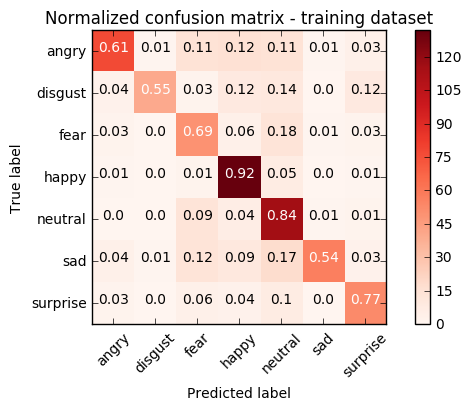

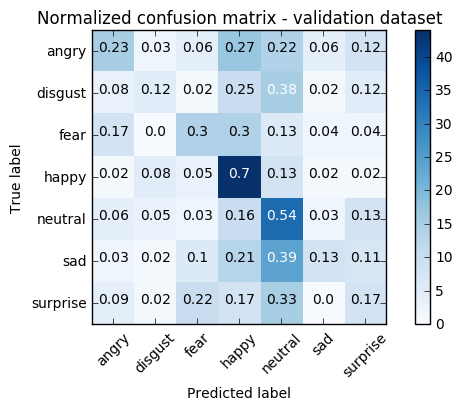

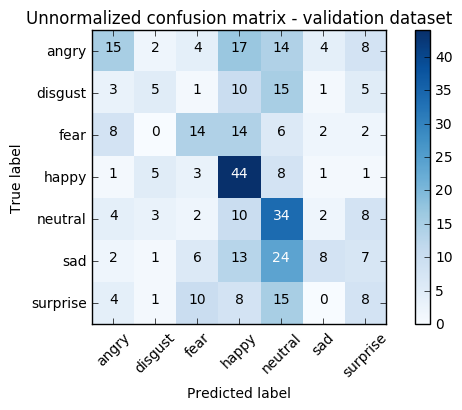

In [18]:
y_pred_training = np.argmax(y_pred_training_, axis=1)
y_pred = np.argmax(y_pred_, axis=1)

plot_confusion_matrix(y_test=y_train, y_pred=y_pred_training,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - training dataset',
                      cmap=plt.cm.Reds)

plot_confusion_matrix(y_test=y_val, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - validation dataset')

plot_confusion_matrix(y_test=y_val, y_pred=y_pred,
                      classes=classes,
                      normalize=False,
                      title='Unnormalized confusion matrix - validation dataset')

# Training history

dict_keys(['acc', 'val_acc', 'loss', 'val_loss'])


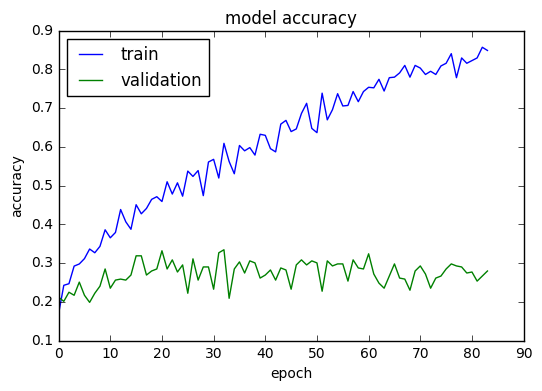

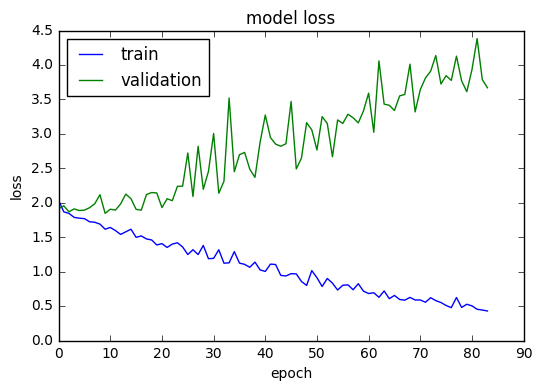

In [19]:
# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()